# About dataset

Our dataset revolves around key hull geometry coefficients and the Froude number, all tied to the vital residuary resistance per unit weight of displacement. These attributes offer deep insights into the hydrodynamic traits of vessels. The dataset is meticulously crafted to support predictive analysis in maritime engineering.

Features and Target
The dataset encapsulates the following features:

LC (Longitudinal Position of Buoyancy): Dimensionless measure of buoyancy center's longitudinal location.
PC (Prismatic Coefficient): Dimensionless coefficient indicating hull volume distribution.
L/D (Length-Displacement Ratio): Dimensionless ratio of vessel length to displacement.
B/Dr (Beam-Draught Ratio): Dimensionless ratio of hull width to depth.
L/B (Length-Beam Ratio): Dimensionless ratio of hull length to width.
Fr (Froude Number): Dimensionless number characterizing flow regime around the hull.
Target
The focus lies on the dimensionless Rr (Residuary Resistance per Unit Weight of Displacement). This quantifies residual resistance in relation to displacement weight, crucial for assessing hydrodynamic efficiency.

Machine Learning Approach
Our goal is to apply machine learning to predict Rr using hull coefficients and the Froude number. By employing regression algorithms, we aim to create predictive models that enhance our understanding of how these attributes influence hydrodynamic resistance. This analysis promises to uncover valuable insights for informed maritime engineering decisions.

In the following sections, we delve into data preprocessing, model selection, parameter tuning, and performance evaluation to unlock deeper insights into the intricate relationship between hull attributes and hydrodynamic behavior

# Libraries

In [1]:
#Import necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import pickle

In [2]:
#call data frame
df=pd.read_csv(r'C:\Users\poory\Desktop\work\projects\Hydrodynamic project\yacht_hydro.csv')

# Preprocessing and visualization

In [3]:
#show five first columns
df.head()

,LC,PC,L/D,B/Dr,L/B,Fr,Rr
0,-2.3,0.568,4.78,3.99,3.17,0.125,0.11
1,-2.3,0.568,4.78,3.99,3.17,0.150,0.27
2,-2.3,0.568,4.78,3.99,3.17,0.175,0.47
3,-2.3,0.568,4.78,3.99,3.17,0.200,0.78
4,-2.3,0.568,4.78,3.99,3.17,0.225,1.18


In [4]:
#describe some statistic information of our dataframe
df.describe()

,LC,PC,L/D,B/Dr,L/B,Fr,Rr
count,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000,308.000000
mean,-2.381818,0.564136,4.788636,3.936818,3.206818,0.287500,10.495357
std,1.513219,0.023290,0.253057,0.548193,0.247998,0.100942,15.160490
min,-5.000000,0.530000,4.340000,2.810000,2.730000,0.125000,0.010000
25%,-2.400000,0.546000,4.770000,3.750000,3.150000,0.200000,0.777500
50%,-2.300000,0.565000,4.780000,3.955000,3.150000,0.287500,3.065000
75%,-2.300000,0.574000,5.100000,4.170000,3.510000,0.375000,12.815000
max,0.000000,0.600000,5.140000,5.350000,3.640000,0.450000,62.420000


### null values

Handling null values is one of the most challenging aspects of preprocessing. Therefore, it's crucial to identify the number of null values in each column. If null values are present, appropriate strategies should be applied to address them effectively.

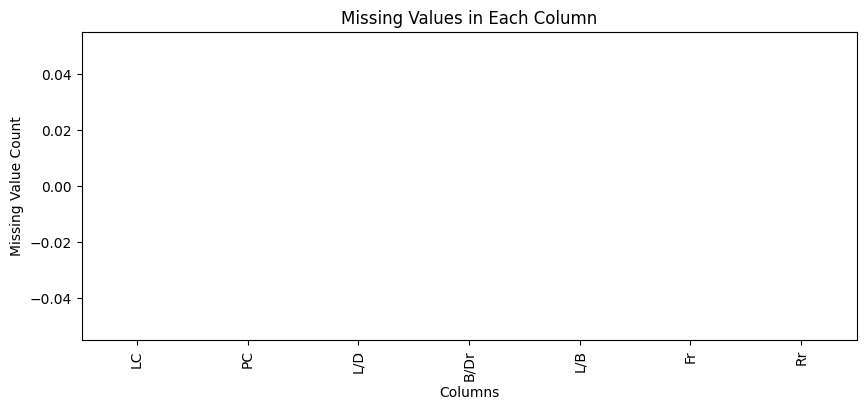

In [5]:
#return the number of null values in each column
missing_values = df.isnull().sum()

#create a barbolt to visualize null values
# Create a bar plot to visualize missing values
plt.figure(figsize=(10, 4))
sns.barplot(x=missing_values.index, y=missing_values.values)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Missing Value Count')
plt.title('Missing Values in Each Column')
plt.show()


As you can observe, there are no null values present in any of the columns.

### Outliers

outliers is another chalOutliers represent another significant challenge in the preprocessing phase. The presence of outliers within our columns can significantly impact the accuracy of our results, necessitating their careful handling.lenging aspect of preprocessing . Existence outlier in our columns can do effect on our accuracy and must handel it

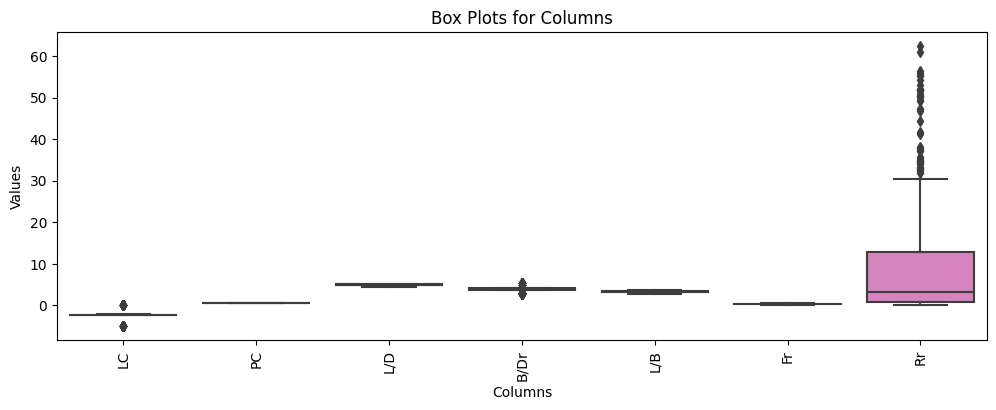

In [6]:
plt.figure(figsize=(12, 4))
sns.boxplot(data=df)
plt.xticks(rotation=90)
plt.xlabel('Columns')
plt.ylabel('Values')
plt.title('Box Plots for Columns')
plt.show()

as you can observe there are outliers present within our columns. Due to the limited number of data points and the sensitivity of our dataset, we refrain from removing or altering these outliers.

### Visualization of Skewness

Skewness poses another significant challenge in preprocessing. In this phase, we examine the standard deviation and skewness of our columns. Detecting deviations from normal distributions, such as a high prevalence of zero values in a specific column, allows us to identify and address potential issues.

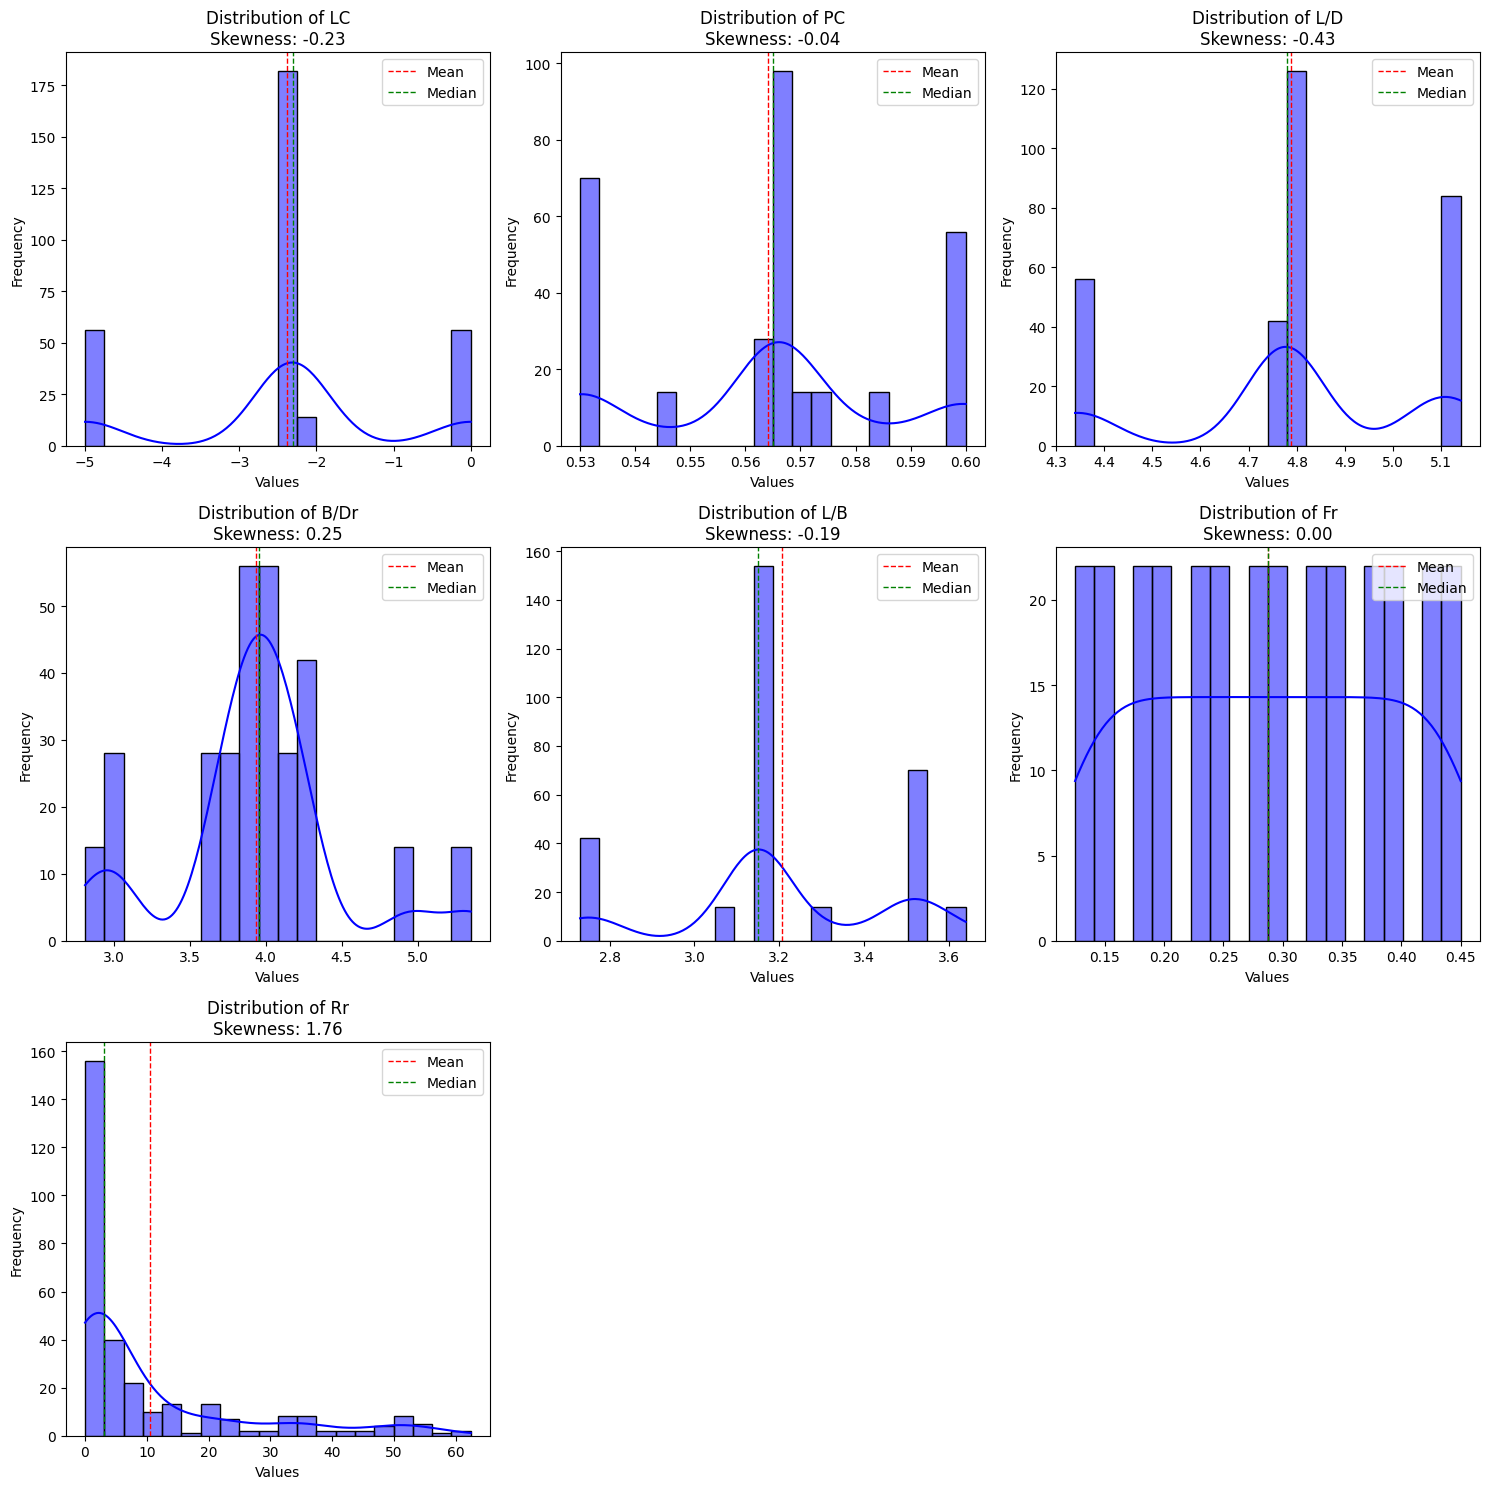

In [7]:
num_cols = 3
num_rows = (df.shape[1] + num_cols - 1) // num_cols

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
fig.subplots_adjust(hspace=0.5)

# Plot each column in a separate subplot
for i, column in enumerate(df.columns):
    ax = axes[i // num_cols, i % num_cols]
    sns.histplot(data=df[column], ax=ax, bins=20, kde=True, color='blue', edgecolor='k')
    ax.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    ax.axvline(df[column].median(), color='green', linestyle='dashed', linewidth=1, label='Median')
    ax.set_title(f'Distribution of {column}\nSkewness: {df[column].skew():.2f}')
    ax.set_xlabel('Values')
    ax.set_ylabel('Frequency')
    ax.legend()

# If the last subplot is not used, remove it
if i + 1 < num_rows * num_cols:
    for j in range(i + 1, num_rows * num_cols):
        fig.delaxes(axes[j // num_cols, j % num_cols])

plt.tight_layout()
plt.show()

With the exception of the target column Rr, the remaining columns exhibit relatively normal distributions and possess acceptable skewness values. Therefore, there is no immediate need for adjustments in these columns.

### heatmap

Using a heatmap, we can effectively visualize the correlations between columns in our dataset. 

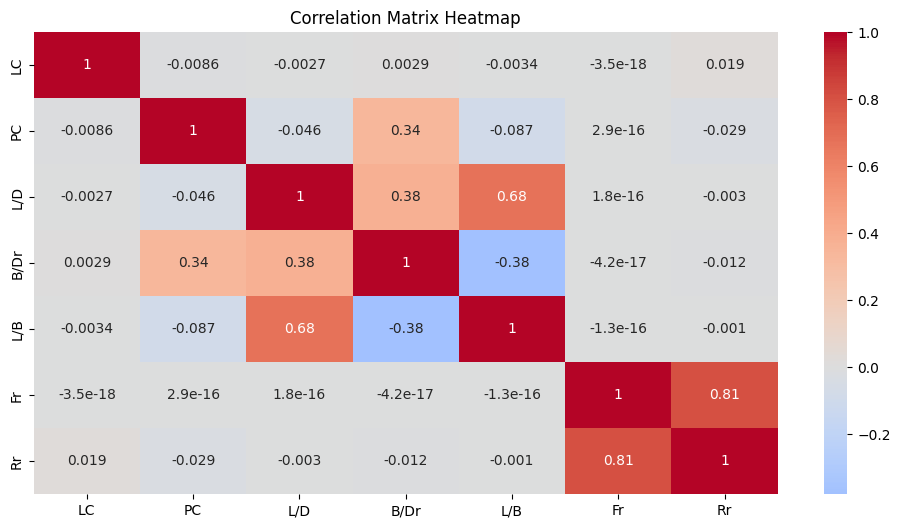

In [8]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix Heatmap')
plt.show()

### scatter plot matrix 

This scatter plot matrix showcases relationships between selected columns and the target 'Rr'. Each subplot illustrates how 'Rr' values correspond to variables such as 'LC', 'PC', 'L/D', 'B/Dr', 'L/B', and 'Fr'. The blue color and transparency help distinguish overlapping data points. Subplots are arranged for clarity, with the size adjusted for optimal visualization. This aids in identifying potential correlations and guiding feature selection.

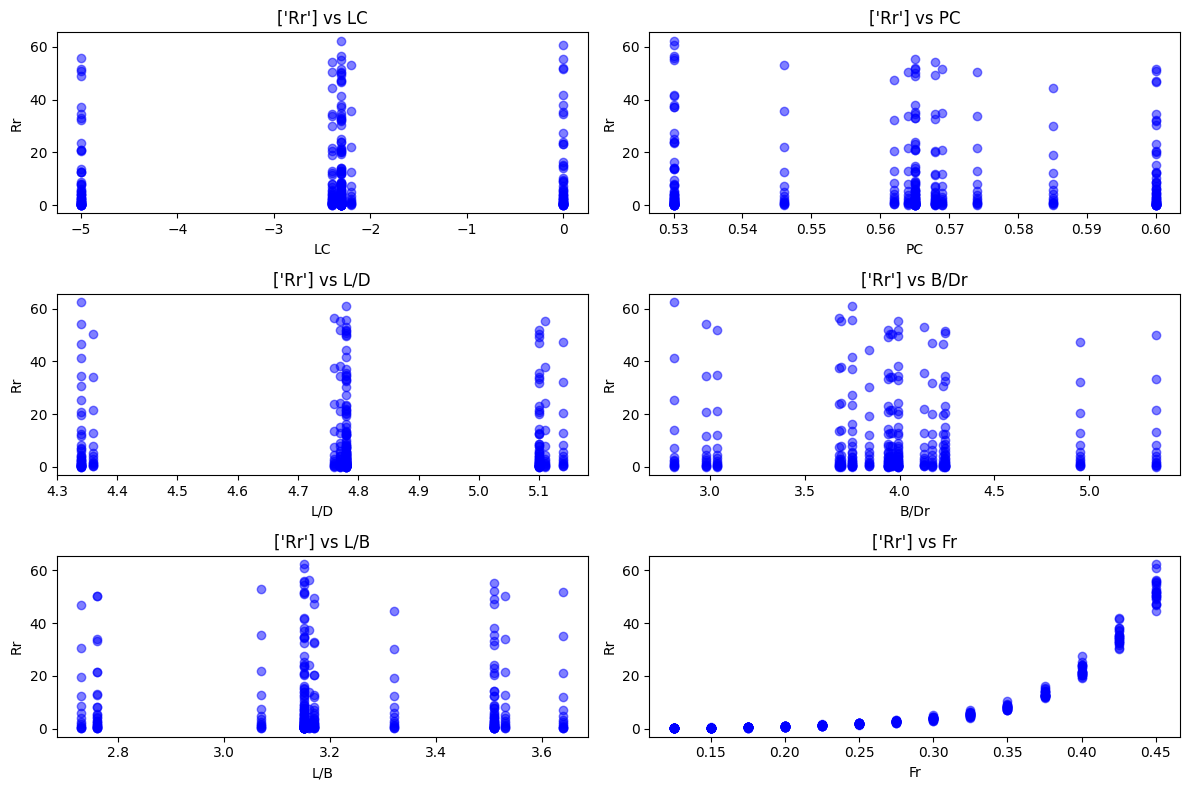

In [9]:
columns_to_compare = ['LC', 'PC', 'L/D', 'B/Dr', 'L/B', 'Fr']
target_column=['Rr']
# Create subplots for each column
num_columns = len(columns_to_compare)
num_rows = (num_columns + 1) // 2
fig, axes = plt.subplots(num_rows, 2, figsize=(12, 8))
fig.subplots_adjust(hspace=0.5)

for i, column in enumerate(columns_to_compare):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    ax.scatter(df[column], df['Rr'], color='blue', alpha=0.5)
    ax.set_xlabel(column)
    ax.set_ylabel('Rr')
    ax.set_title(f'{target_column} vs {column}')

# If the number of columns is odd, remove the empty subplot
if num_columns % 2 == 1:
    fig.delaxes(axes[num_rows - 1, 1])

plt.tight_layout()
plt.show()

### Data Preparation and Train-Test Split

In this section, our initial steps involve separating the target variable from the features. As the values in our dataset exhibit an ordered structure from least to most, shuffling is employed to introduce randomness. This randomization ensures that the training and testing sets are representative and not biased by the inherent order of values. The shuffled data is then utilized to create distinct training and testing subsets, setting the foundation for subsequent analysis and modeling.

In [10]:
target=df['Rr']#Extract the 'R2' column as the target
df.drop(['Rr'],axis=1,inplace=True)#Drop the 'R2' column from the Dataframe

In [11]:
#Shuffle features and target using a random seed
x_shuffled, y_shuffled = shuffle(df, target, random_state=42)

In [12]:
#Split shuffled features into train and test sets
x_train,x_test,y_train,y_test=train_test_split(x_shuffled,y_shuffled,test_size=0.3,random_state=42)

In [13]:
y_test

252     0.16
46      1.37
198     0.47
224     0.03
173     1.76
       ...  
170     0.45
94     12.80
168     0.08
2       0.47
208    37.38
Name: Rr, Length: 93, dtype: float64

# Machine learning prediction

In this section, our objective is to leverage machine learning models for predictive analysis. We explore several machine learning algorithms and employ grid search techniques to identify the optimal parameters that yield the best performance. After evaluating various models, we select the one exhibiting the highest accuracy for our project's needs. Our chosen evaluation metric is the mean squared error, which enables us to assess the quality of predictions in comparison to actual values.

The machine learning models we utilize in our analysis comprise the following:

RandomForestRegressor,
ExtraTreesRegressor,
AdaBoostRegressor,
Support Vector Regression (SVR),
XGBoostRegressor,
CatBoostRegressor,
These models form the foundation of our exploration, enabling us to predict and assess outcomes in the context of our project.


### XGBoostRegressor

In [14]:
#Define the XGBoost regressor model
xgboost_model=XGBRegressor()

In [15]:
#Specify the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

In [16]:
#Create a grid search object for hyperparameter tuning
grid_search = GridSearchCV(xgboost_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [17]:
#Fit the grid search to the training data
grid_search.fit(x_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [18]:
#Retrieve the best parameters from the grid search
best_params = grid_search.best_params_

In [19]:
#Get the best model from the grid search
XGB_best_model = grid_search.best_estimator_

In [20]:
#Make predictions using the best model
y_pred = XGB_best_model.predict(x_test)

In [21]:
#Calculate the root mean squared error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [22]:
print(f"Best Parameters: {best_params}")#Display the best parameters
print(f"Root Mean Squared Error: {rmse:.2f}")#Show the RMSE

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}
Root Mean Squared Error: 0.54


Result of RandomForestRegressor is  <span style="color:red;">0.54</span>.

Visualizing the model's predictions, a scatter plot is created to compare predicted and actual values. This aids in assessing how accurately the model approximates the target values.

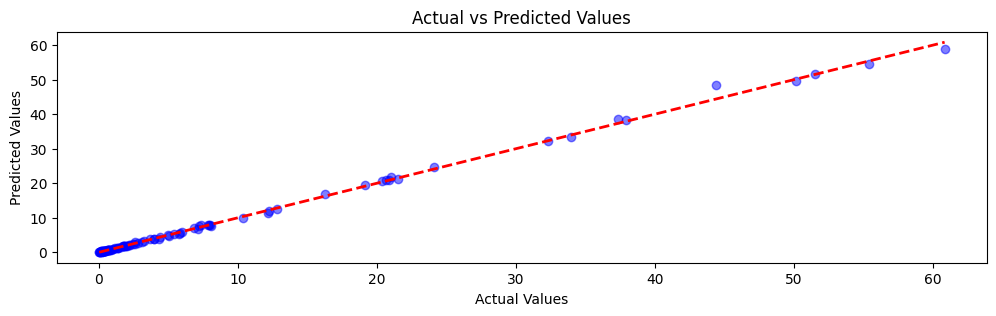

In [23]:
plt.figure(figsize=(12, 3))#Create a scatter plot figure with the specified size
#Scatter plot of predicted vs. actual values
plt.scatter(y_test, y_pred, color='blue', label='Predicted', alpha=0.5)
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2, label='Actual')
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs Predicted Values')#Display the legend
plt.show()#Show the plot

### CatBoostRegressor

In [24]:
#Define the CatBoostRegressor model
catboost_model = CatBoostRegressor()

In [25]:
#Specify the parameter grid for hyperparameter tuning
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'n_estimators': [100, 200, 300]
}

In [26]:
# Create a grid search object
grid_search = GridSearchCV(catboost_model, param_grid, cv=5, scoring='neg_mean_squared_error')

In [ ]:
# Fit the grid search to the training data
grid_search.fit(x_train, y_train)

In [28]:
# Get the best parameters and best estimator from the grid search
best_params = grid_search.best_params_

In [29]:
#Get the best model from the grid search
best_model = grid_search.best_estimator_

In [30]:
# Make predictions on the test set using the best model
y_pred = best_model.predict(x_test)

In [31]:
# Calculate and print the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [32]:
print(f"Best Parameters: {best_params}")#Display the best parameters

Best Parameters: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}


In [33]:
print(f"Root Mean Squared Error: {rmse:.2f}")#Show the RMSE

Root Mean Squared Error: 0.82


Result of CatBoostRegressor is  <span style="color:red;">0.82</span>.

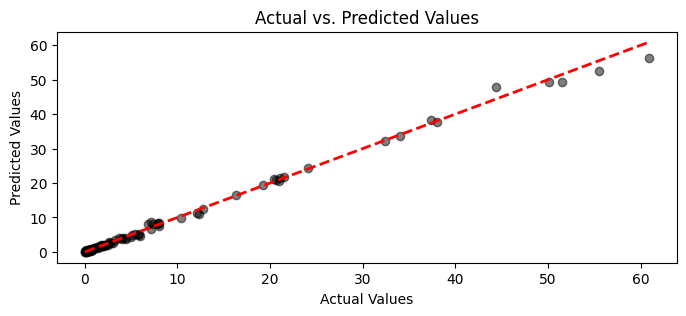

In [34]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred, color='black', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

### ExtraTreesRegressor

In [35]:
#Define the CatBoostRegressor model`
et_model = ExtraTreesRegressor()

In [36]:
#Specify the parameter grid for hyperparameter tuning
param_grid_et = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [37]:
# Create a grid search object
grid_search_et = GridSearchCV(et_model, param_grid_et, cv=5, scoring='neg_mean_squared_error')

In [38]:
# Fit the grid search to the training data
grid_search_et.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=ExtraTreesRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [39]:
#Get the best model from the grid search
best_et_model = grid_search_et.best_estimator_


In [40]:
# Make predictions on the test set using the best model
y_pred_et = best_et_model.predict(x_test)

In [41]:
## Calculate and print the Root Mean Squared Error (RMSE) for ExtraTreesRegressor
rmse_et = np.sqrt(mean_squared_error(y_test, y_pred_et))

In [42]:
print(f"Extra Trees - Root Mean Squared Error: {rmse_et:.2f}")#Show the RMSE

Extra Trees - Root Mean Squared Error: 1.05


Result of CatBoostRegressor is  <span style="color:red;">1.06</span>.

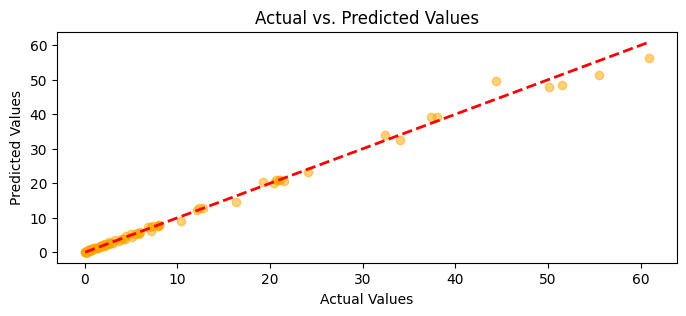

In [43]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_et, color='orange', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

# Support Vector Regression (SVR)

In [44]:
#Define the Support vector regression model
svm_model = SVR()

In [45]:
# Define the parameter grid for grid search
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid']
}

In [46]:
# Create grid search objects
grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, scoring='neg_mean_squared_error')

In [47]:
# Fit the grid search to the training data
grid_search_svm.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid={'C': [0.1, 1, 10],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='neg_mean_squared_error')

In [48]:
# Get the best estimators from the grid search
best_svm_model = grid_search_svm.best_estimator_

In [49]:
# Make predictions on the test set using the best models
y_pred_svm = best_svm_model.predict(x_test)

In [50]:
# Calculate and print the Root Mean Squared Error (RMSE) for Support vector regression model
rmse_svm = np.sqrt(mean_squared_error(y_test, y_pred_svm))

In [51]:
print(f"SVM - Root Mean Squared Error: {rmse_svm:.2f}")#Show the RMSE

SVM - Root Mean Squared Error: 10.62


Result of CatBoostRegressor is  <span style="color:red;">10.62</span>.

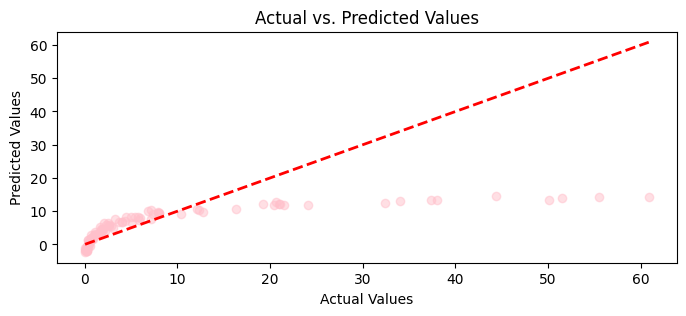

In [52]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_svm, color='pink', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot


### RandomForestRegressor

In [53]:
# Create andomForestRegressor models
rf_model = RandomForestRegressor()

In [54]:
# Define the parameter grid for grid search
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

In [55]:
# Create grid search objects
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=5, scoring='neg_mean_squared_error')

In [56]:
# Fit the grid search to the training data
grid_search_rf.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [None, 10, 20],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error')

In [57]:
# Get the best estimators from the grid search
best_rf_model = grid_search_rf.best_estimator_

In [58]:
# Make predictions on the test set using the best models
y_pred_rf = best_rf_model.predict(x_test)

In [59]:
# Calculate and print the Root Mean Squared Error (RMSE) for each model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

In [60]:
print(f"Random Forest - Root Mean Squared Error: {rmse_rf:.2f}")#Show the RMSE

Random Forest - Root Mean Squared Error: 1.17


Result of CatBoostRegressor is  <span style="color:red;">1.18</span>.

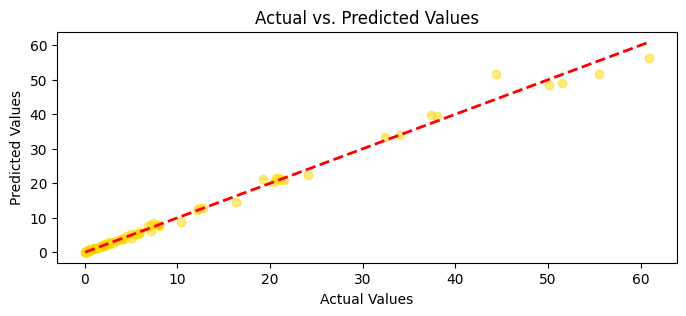

In [61]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_rf, color='Gold', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

### AdaBoostRegressor

In [62]:
# Create models
ab_model = AdaBoostRegressor()

In [63]:
# Define the parameter grid for grid search
param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2]
}

In [64]:
# Create grid search objects
grid_search_ab = GridSearchCV(ab_model, param_grid_ab, cv=5, scoring='neg_mean_squared_error')

In [65]:
# Fit the grid search to the training data
grid_search_ab.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=AdaBoostRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'n_estimators': [50, 100, 200]},
             scoring='neg_mean_squared_error')

In [66]:
# Get the best estimators from the grid search
best_ab_model = grid_search_ab.best_estimator_

In [67]:
# Make predictions on the test set using the best models
y_pred_ab = best_ab_model.predict(x_test)

In [68]:
# Calculate and print the Root Mean Squared Error (RMSE) for AdaBoostRegressor
rmse_ab = np.sqrt(mean_squared_error(y_test, y_pred_ab))

In [69]:
print(f"AdaBoost - Root Mean Squared Error: {rmse_ab:.2f}")#Show the RMSE

AdaBoost - Root Mean Squared Error: 1.53


Result of CatBoostRegressor is  <span style="color:red;">1.40</span>.

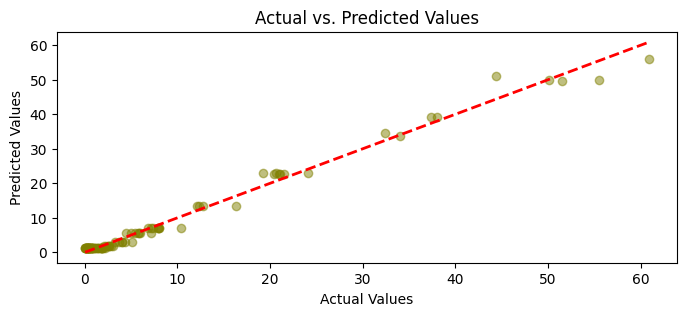

In [70]:
plt.figure(figsize=(8, 3))# Visualize the predicted vs. actual values
plt.scatter(y_test, y_pred_ab, color='Olive', alpha=0.5)#Scatter plot of predicted vs. actual values
#Add a red dashed line representing actual vs. actual values
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Values')#Set the x-axis label
plt.ylabel('Predicted Values')#Set the y-axis label
plt.title('Actual vs. Predicted Values')#Display the legend
plt.show()#Show the plot

## Save the XGBoostRegressor weights

In [71]:
# Save the trained XGBoost model using pickle
with open('xgb_model.pkl', 'wb') as model_file:
    pickle.dump(XGB_best_model, model_file)

## Colorful Model Performance Visualization

Explore the performance summary of different regression models based on their Root Mean Squared Error (RMSE) values. This visualization showcases the varying predictive capabilities of each model.

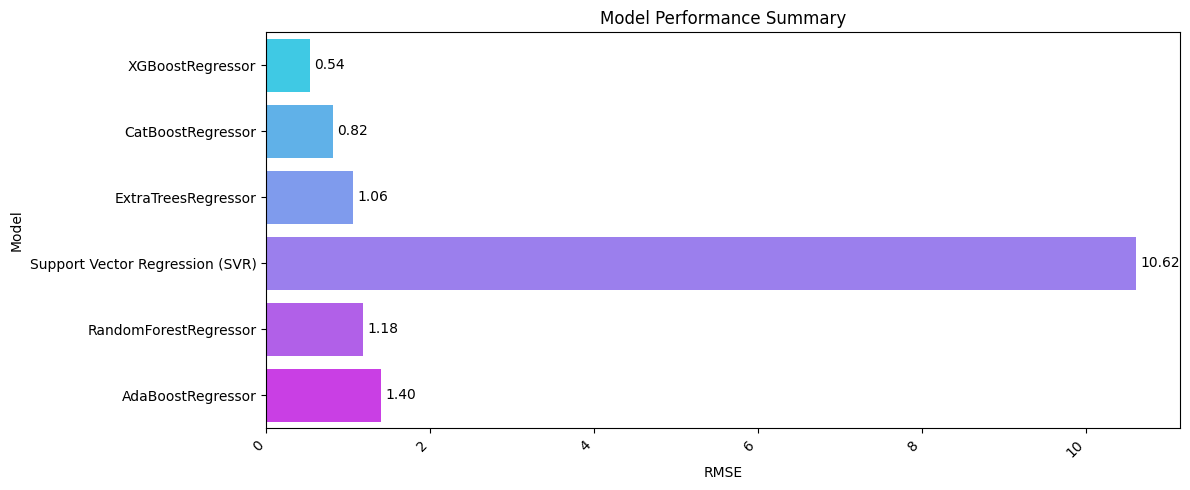

In [72]:
# Data
data = {
    "Model": ["XGBoostRegressor", "CatBoostRegressor", "ExtraTreesRegressor", "Support Vector Regression (SVR)", "RandomForestRegressor", "AdaBoostRegressor"],
    "RMSE": [0.54, 0.82, 1.06, 10.62, 1.18, 1.40],
}

# Create DataFrame
df = pd.DataFrame(data)

# Set color palette
colors = sns.color_palette("cool")

# Create a bar plot
plt.figure(figsize=(12, 5))
sns.barplot(x="RMSE", y="Model", data=df, palette=colors)
plt.xlabel("RMSE")
plt.ylabel("Model")
plt.title("Model Performance Summary")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Add RMSE values as text
for index, row in df.iterrows():
    plt.text(row["RMSE"] + 0.05, index, f"{row['RMSE']:.2f}", va="center", fontsize=10, color="black")

plt.show()


# Conclusion

In this project, we explored the interplay between hull geometry coefficients, the Froude number, and residuary resistance per unit weight of displacement (Rr) in maritime engineering. Through data preprocessing, visualization, and machine learning, we aimed to predict Rr accurately, enhancing our understanding of hydrodynamics.

After thorough analysis, the XGBoost model emerged as the standout performer, yielding the lowest Root Mean Squared Error (RMSE). Leveraging its predictive prowess, we selected XGBoost to make weighty predictions in the context of maritime resistance, benefitting vessel design and efficiency.

